In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
from utils.utils import *
from dtw import dtw
import optuna


np.random.seed(2)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


#### Import data

In [3]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [6]:
file_dir = r'D:\Study 2 Data\sample_healthy_data'
train_files = os.listdir(file_dir) 

os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\sample_healthy_data
There are 3 files in the specified path.


In [7]:
train_files

['AB2188 BF T1-5.csv', 'AB3154 BF T6-10.csv', 'AB9738 BF T1-5.csv']

In [8]:
#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [9]:
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv
Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv


In [10]:
all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [11]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
22196,AB9738 BF T1-5,10,357.98,10.99086,7.10503,6.93556,24.15779,24.79361,-6.96295
22197,AB9738 BF T1-5,10,357.99,10.66388,6.95092,7.04563,23.36649,23.37365,-6.78526
22198,AB9738 BF T1-5,10,358.00,10.47453,6.99232,7.14855,22.59988,22.00132,-6.50384
22199,AB9738 BF T1-5,10,358.01,10.44759,7.27248,7.23479,21.89250,20.71157,-6.14128


In [12]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 10


In [13]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB9738 BF T1-5'],
      dtype=object)

In [14]:
# Divide subjects into training and validation set
train_subjects = ['AB2188 BF T1-5', 
                  'AB3154 BF T6-10',]

val_subjects = ['AB9738 BF T1-5']

In [15]:
val_subjects

['AB9738 BF T1-5']

In [16]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

In [17]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')

all_data: (22201, 9)
train_data: (13769, 9)
val_data: (8432, 9)


In [18]:
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)

For patient: AB2188 BF T1-5, trial: 1, there are: 718 time-points
For patient: AB2188 BF T1-5, trial: 2, there are: 801 time-points
For patient: AB2188 BF T1-5, trial: 3, there are: 706 time-points
For patient: AB2188 BF T1-5, trial: 4, there are: 651 time-points
For patient: AB2188 BF T1-5, trial: 5, there are: 741 time-points
For patient: AB2188 BF T1-5, trial: 6, there are: 691 time-points
For patient: AB2188 BF T1-5, trial: 7, there are: 722 time-points
For patient: AB2188 BF T1-5, trial: 8, there are: 726 time-points
For patient: AB2188 BF T1-5, trial: 9, there are: 740 time-points
For patient: AB2188 BF T1-5, trial: 10, there are: 766 time-points
For patient: AB3154 BF T6-10, trial: 1, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4, there are: 601 time-points
For patient: AB3154 BF T6-10, trial: 5, there are: 711 time-points
For 

In [19]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')

Number of train samples: 19
Number of validation samples: 9


In [20]:
m = all_data['Patient ID'].unique()

In [21]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')

train_data_np.shape: (19, 2000, 6)
val_data_np.shape: (9, 2000, 6)


In [22]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [23]:
features == train_columns[3:].tolist() 

True

In [24]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers 'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

Column headers of dataframe match features


In [25]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

In [26]:
# Creating training datasets
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float64) 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float64) 


start_idx = 0 
train_sample_sum = 0
train_excluded_samples = []

# Create training windows 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 418
number of slides is: 318
trimmed_seqLen: 801
trimmed_seqLen_reduced: 501
number of slides is: 401
trimmed_seqLen: 706
trimmed_seqLen_reduced: 406
number of slides is: 306
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 741
trimmed_seqLen_reduced: 441
number of slides is: 341
trimmed_seqLen: 691
trimmed_seqLen_reduced: 391
number of slides is: 291
trimmed_seqLen: 722
trimmed_seqLen_reduced: 422
number of slides is: 322
trimmed_seqLen: 726
trimmed_seqLen_reduced: 426
number of slides is: 326
trimmed_seqLen: 740
trimmed_seqLen_reduced: 440
number of slides is: 340
trimmed_seqLen: 766
trimmed_seqLen_reduced: 466
number of slides is: 366
trimmed_seqLen: 651
trimmed_seqLen_reduced: 351
number of slides is: 251
trimmed_seqLen: 541
trimmed_seqLen_reduced: 241
number of slides is: 141
trimmed_seqLen: 613
trimmed_seqLen_reduced: 313
number of slides is: 213
trimmed_seqLen: 601
trimmed_seqLen_reduced: 301
num

In [27]:
# Creating validation datasets
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float64) 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float64) 


start_idx = 0
val_sample_sum = 0
val_excluded_samples = []


for i in range(val_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_windows[start_idx:end_idx, :, :] = X_values
    Y_val_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 496
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 581
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 601
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 506
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 558
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 551
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 504
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 526
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 509
shape of X_val_windows: (14400, 100, 6)
shape of Y_val_windows: (14400, 1, 6)
shape of X_val_data: (4832, 100, 6)
shape of Y_val_data: (4832, 1, 6)


In [28]:
# Creating validation datasets (long term predictions)
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float64) 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float64) 


start_idx = 0 
val_lt_sample_sum = 0
val_lt_excluded_samples = []


for i in range(val_samples): 
       
    X_values, Y_values = window_generator_lt_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        future_window=future_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_lt_windows[start_idx:end_idx, :, :] = X_values
    Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_lt_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 382
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 402
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 307
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 359
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 352
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 305
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 327
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 310
shape of X_val_lt_windows: (14400, 100, 6)
shape of Y_val_lt_windows: (14400, 200, 6)
shape of X_val_lt_data: (3041, 100, 6)
shape of Y_val_lt_data: (3041, 200, 6)


In [29]:
X_train_norm, scalars = normalise_fit(X_train_data)
Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)

In [30]:
# Convert to Tensor 
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions




X_train shape: torch.Size([6169, 100, 6])
Y_train shape: torch.Size([6169, 1, 6])
X_val shape: torch.Size([4832, 100, 6])
Y_val shape: torch.Size([4832, 1, 6])
X_val_lt shape: torch.Size([3041, 100, 6])
Y_val_lt shape: torch.Size([3041, 200, 6])


In [31]:
X_val.dtype

torch.float64

## Model Architecture


In [32]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([6169, 100, 6]), shape of Y_train: torch.Size([6169, 1, 6])


In [33]:
# LSTM model 
class LSTM(nn.Module):
    def __init__(self, params):
        super(LSTM, self).__init__()

        self.hidden_size = params['hidden_size']
        self.num_layers = params['num_layers']
        self.in_seq_len = 100
        self.output_size = len(features)
        self.out_seq_len = output_window
        self.device = DEVICE
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first = True)

        self.fc1 = nn.Linear(in_features=self.hidden_size, out_features=(self.output_size * self.out_seq_len))

    def forward(self, input_data):

        h_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device) 
        c_0 = torch.zeros(self.num_layers, input_data.shape[0], self.hidden_size).double().to(self.device)

        lstm_out, (h_out, c_out) = self.lstm(input_data, (h_0, c_0))
        fc1_out = self.fc1(h_out[-1])
       
        preds = fc1_out.reshape(input_data.shape[0], self.out_seq_len, self.output_size)
        
        return preds

In [34]:
class MLP(nn.Module):
    def __init__(self, params):
        super(MLP, self).__init__()
        self.input_size = len(features)
        self.output_size = len(features)
        self.in_seq_len = 100
        self.out_seq_len = 1
        self.device = DEVICE 
        self.layers = params['layers']
        self.num_units = params['num_units']
        

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)

        linear_layers_lst = [] #linear layer list
 
        for i in range(self.layers):
            linear_layers_lst.append(nn.Linear(self.num_units, self.num_units))
            linear_layers_lst.append(nn.ReLU())

       
        linear_layers = tuple((linear_layers_lst))

        self.MLP = nn.Sequential(nn.Linear(in_features=self.input_size*self.in_seq_len, out_features=self.num_units), 
                                nn.ReLU(), 
                                *linear_layers, 
                                nn.Linear(self.num_units, self.output_size*self.out_seq_len))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.flatten(x)
        out = self.MLP(out)
        out = self.sigmoid(out)
        preds = out.reshape(x.shape[0],  self.out_seq_len,self.output_size)
        return preds


In [35]:
class CNN(nn.Module):
    def __init__(self, params):
        super(CNN, self).__init__()

        self.input_size = len(features)
        self.output_size = len(features)
        # self.kernel_size = kernel_size
        # self.stride = stride
        self.device = DEVICE 
        self.in_seq_len = input_window
        self.out_seq_len = output_window
        self.conv1_channels = params['conv1_channels']
        self.conv2_channels = params['conv2_channels']
        self.conv3_channels = params['conv3_channels']
        self.conv4_channels = params['conv4_channels']
        self.kernel_12 = params['kernel_12']
        self.kernel_34 = params['kernel_34']
        self.padding = params['padding']
        self.stride = params['stride']
        self.dilation = params['dilation']

        def calc_shape(input, kernel_size, stride, padding=0, dilation =1, operation = 'conv'):
            if operation == 'conv':
                size = ((input + 2 * padding - dilation * (kernel_size-1) -1)/stride )+ 1

            if operation == 'pool':
                size = ((input - kernel_size)/stride)  + 1

            return size

        self.conv1 = nn.Conv1d(in_channels = self.input_size, out_channels = self.conv1_channels, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding, dilation=self.dilation)
        post_conv1 = calc_shape(input = self.in_seq_len, kernel_size = self.kernel_12, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')

        self.conv2 = nn.Conv1d(in_channels = self.conv1_channels, out_channels = self.conv2_channels, kernel_size = self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv2 = calc_shape(input = post_conv1, kernel_size =self.kernel_12 , stride = self.stride, padding = self.padding,  dilation=self.dilation,  operation='conv')

        self.pool1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool1 = calc_shape(input = post_conv2, kernel_size = 2, stride = 2,  operation='pool')

        self.conv3 = nn.Conv1d(in_channels=self.conv2_channels, out_channels=self.conv3_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation )
        post_conv3 = calc_shape(input = post_pool1, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding, dilation=self.dilation, operation='conv')

        self.conv4 = nn.Conv1d(in_channels=self.conv3_channels, out_channels=self.conv4_channels, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation)
        post_conv4 = calc_shape(input = post_conv3, kernel_size = self.kernel_34, stride = self.stride, padding = self.padding,  dilation=self.dilation, operation='conv')

        self.pool2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        post_pool2 = calc_shape(input = post_conv4, kernel_size = 2, stride = 2,  operation='pool')

        self.fc1 = nn.Linear(in_features = (int(post_pool2) * self.conv4_channels), out_features=(self.output_size * self.out_seq_len))


    def forward(self, input_data):

        input = input_data.permute(0,2,1)
        out = self.conv1(input)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.pool2(out)
        out = torch.flatten(out, start_dim = 1, end_dim=-1) #do not flatten batches 
        out = self.fc1(out)
        preds = out.reshape(input_data.shape[0],  self.out_seq_len, self.output_size)
        return preds

In [36]:
DEVICE = 'cuda'

In [38]:
fname = 'FCN'
folder_path = r'D:\Study 2 Results and Models\sample-model\HPO' + '\\' + fname 
path = r'D:\Study 2 Results and Models\sample-model\HPO'+ '\\' + fname + '\\'  + fname + '.pth'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    print('File already exists, choose a different name')
    raise 
    

In [39]:
global trial_number
trial_number = 0
trial_descrbn = 'FCN'

In [40]:
train_dataset = gaitDataset(X_train, Y_train)
val_dataset = gaitDataset(X_val, Y_val)
val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions


## Training

In [56]:
def train_model(model, train_dataset, val_dataset, val_lt_dataset, params):
    global trial_number

    train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=True)
    val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=params['batch_size'], shuffle=True)

    
    MODEL_PATH= folder_path + '\\'  + str(trial_descrbn) + '-' + 'trial' + str(trial_number) + '.pt'

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    train_loss = []
    val_loss = []
    lt_loss = []
    dtw_loss = []

    lowest_dtw = 1000.

    for epoch in tqdm(range(10)):
        train_loss_total = 0.
        i = 0
        model.train()
        for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
            i += 1
            model.zero_grad()

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            
            predictions = model(batch_inputs)

            loss = loss_function(predictions, batch_targets)

            train_loss_total += loss.item()
            loss.backward()
            optimizer.step()
        train_loss_total = train_loss_total/len(train_dataloader)
        train_loss.append(train_loss_total)

        # Calculate validation loss
        model.eval()
        with torch.no_grad():
            val_loss_total = 0.
            for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
                

                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                predictions = model(batch_inputs)
                loss = loss_function(predictions, batch_targets)
                val_loss_total += loss.item()
        
        val_loss_total = val_loss_total/len(val_dataloader)
        val_loss.append(val_loss_total)

        # Calculating long term loss
        model.eval()
        with torch.no_grad():
            lt_loss_total = 0.
            dtw_total = 0.

            for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

                extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)

                batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
                current_inputs = batch_inputs
                for i in range(200):
                    predictions = model(current_inputs)

                    extrapolation[:,i,:] = predictions.squeeze(1)

                    current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

                loss = loss_function(extrapolation, batch_targets)
        
                lt_loss_total += loss.item()

                #dtw
                running_dtw = 0.
                for s in range(batch_targets.shape[0]):
                    for f in range(len(features)):
                        dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                        
                        running_dtw += dis

                dtw_total += running_dtw / (batch_targets.shape[0] * len(features))

        lt_loss_total = lt_loss_total/len(val_lt_dataloader)
        lt_loss.append(lt_loss_total)

        dtw_total = dtw_total / (len(val_lt_dataloader))
        dtw_loss.append(dtw_total)

        if dtw_total < lowest_dtw:
            lowest_dtw = dtw_total

            checkpoint = {'model': model,
                    'state_dict': model.state_dict(),
                    'epoch': epoch+1,
                    'optimizer' : optimizer.state_dict(),
                    'val_loss': val_loss_total, 
                    'dtw_distance': dtw_total,
                    }

            torch.save(checkpoint, MODEL_PATH)
    
    trial_number+=1
    return lowest_dtw

        

## Defining Hyperparameter Search Space

In [57]:
#CNN
def objective(trial):

    params = {
            'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            'batch_size': trial.suggest_categorical('batch_size', [32,64,128,256,512]),   
            'conv1_channels': trial.suggest_categorical('conv1_channels', [16, 32, 48]),
            'conv2_channels': trial.suggest_categorical('conv2_channels', [32, 48, 64]),
            'conv3_channels': trial.suggest_categorical('conv3_channels', [64, 128, 256]),
            'conv4_channels': trial.suggest_categorical('conv4_channels', [128, 256, 512]),
            'kernel_12': trial.suggest_int('kernel_12', 1, 5),
            'kernel_34': trial.suggest_int('kernel_34', 1, 5),
            'padding':trial.suggest_int('padding', 0, 4),
            'stride':trial.suggest_int('stride', 1,4),
            'dilation': trial.suggest_categorical('dilation', [1,2,4])
            }


    for t in trial.study.trials:
        # print(t)
        if t.state != optuna.structs.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            global trial_number
            trial_number += 1
            return t.value
            
    try:
        model = CNN(params).double().to(DEVICE)
        
        dtw_distance = train_model(model, train_dataset, val_dataset, val_lt_dataset, params)
    
    except Exception:
        dtw_distance=1000000

    return dtw_distance



In [58]:
#LSTM
def objective(trial):

    params = {
              'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
              'num_layers': trial.suggest_categorical('num_layers', [1,2,3,4]),
              'hidden_size': trial.suggest_categorical('hidden_size', [4,8,16,32,64]), 
              'batch_size': trial.suggest_categorical('batch_size', [32,64,128,256,512])
              }

    for t in trial.study.trials:
        if t.state != optuna.structs.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            global trial_number
            trial_number += 1
            return t.value
            
    
    model = LSTM(params).double().to(DEVICE)
    
    dtw_distance = train_model(model, train_dataset, val_dataset, val_lt_dataset, params)

    return dtw_distance

In [59]:
#FCN
def objective(trial):

    params = {           
            'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001, 0.0001, 0.00001]),
            'layers': trial.suggest_categorical('layers', [1,2,3,4,6,8,10]),
            'num_units': trial.suggest_categorical('num_units', [10,30,50,70,100,130,150,200]),
            'batch_size': trial.suggest_categorical('batch_size', [32,64,128,256,512])           
            }

    for t in trial.study.trials:
        if t.state != optuna.structs.TrialState.COMPLETE:
            continue

        if t.params == trial.params:
            global trial_number
            trial_number += 1
            return t.value
            
    
    model = MLP(params).double().to(DEVICE)
    
    dtw_distance = train_model(model, train_dataset, val_dataset, val_lt_dataset, params)

    return dtw_distance

## Hyperparameter Optimisation

In [60]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=70)

[I 2023-08-27 16:10:25,709] A new study created in memory with name: no-name-b64a9cd9-3c3b-4167-9eb0-15b7d172a7ad


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-27 16:16:56,089] Trial 0 finished with value: 11.277119748398873 and parameters: {'learning_rate': 0.001, 'layers': 6, 'num_units': 200, 'batch_size': 64}. Best is trial 0 with value: 11.277119748398873.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-27 16:25:02,106] Trial 1 finished with value: 17.772618775408016 and parameters: {'learning_rate': 0.0001, 'layers': 10, 'num_units': 70, 'batch_size': 64}. Best is trial 0 with value: 11.277119748398873.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-08-27 16:30:41,898] Trial 2 finished with value: 10.004186530037746 and parameters: {'learning_rate': 0.01, 'layers': 3, 'num_units': 150, 'batch_size': 256}. Best is trial 2 with value: 10.004186530037746.


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [61]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [62]:
fig = optuna.visualization.plot_parallel_coordinate(study,params=['learning_rate','layers','num_units','batch_size'])
fig.show()

C:\Users\Rania\AppData\Local\Temp/ipykernel_9328/4150784049.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



array([<AxesSubplot:xlabel='batch_size', ylabel='Objective Value'>,
       <AxesSubplot:xlabel='layers'>,
       <AxesSubplot:xlabel='learning_rate'>,
       <AxesSubplot:xlabel='num_units'>], dtype=object)

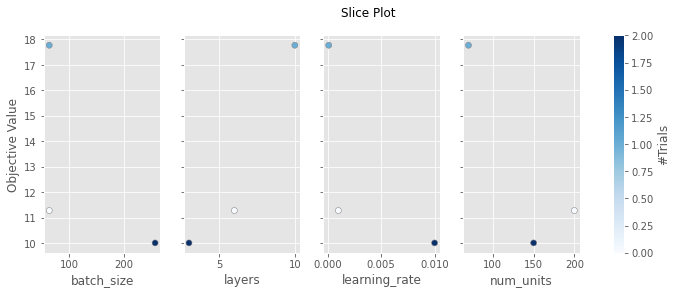

In [63]:
optuna.visualization.matplotlib.plot_slice(study, params=['learning_rate','layers','num_units','batch_size'])

C:\Users\Rania\AppData\Local\Temp/ipykernel_9328/3770046964.py:3: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2023-08-27 16:34:09,139] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<AxesSubplot:ylabel='batch_size'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='layers'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='learning_rate'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='batch_size', ylabel='num_units'>,
        <AxesSubplot:xlabel='layers'>,
        <AxesSubplot:xlabel='learning_rate'>,
        <AxesSubplot:xlabel='num_units'>]], dtype=object)

<Figure size 640x480 with 0 Axes>

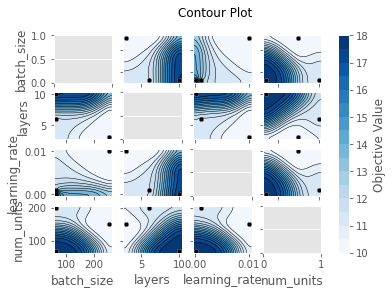

In [64]:
figure(figsize=(8, 6), dpi=80)

optuna.visualization.matplotlib.plot_contour(study, params=['learning_rate','layers','num_units','batch_size'])

## Load Optimial Model Parameters

In [ ]:
MODEL_PATH= r''

model_file = os.listdir(MODEL_PATH) 

os.chdir(MODEL_PATH)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}') 
print(f"There are {len(model_file)} files in the specified path.")

In [ ]:
for f in model_file:
    if f.endswith((".pt")):
        checkpoint = torch.load(f)
        best_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['val_loss']
        dtw_total = checkpoint['dtw_distance']

        print(f'{f}: best_epoch: {best_epoch}, best_val_loss: {best_val_loss:.5f}, dtw_distance: {dtw_total:.5f}')